### Data Loading

Load in Data from .mat files

In [9]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import load_subject_high_gamma

In [10]:
hg_trace, hg_map, phon_labels = load_subject_high_gamma('S14', sig_channel=True, zscore=False)

(144, 200, 111)
(144, 8, 16, 200)
(144, 3)


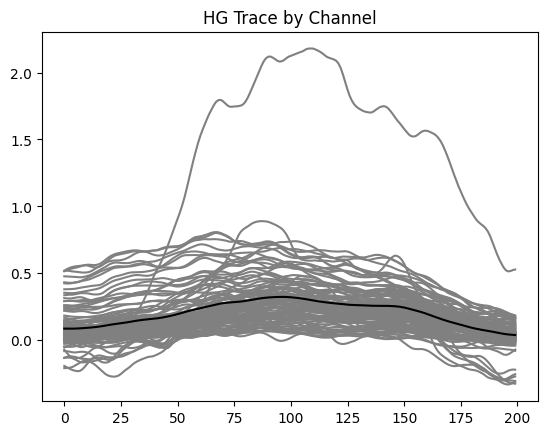

In [11]:
print(hg_trace.shape)
print(hg_map.shape)
print(phon_labels.shape)

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

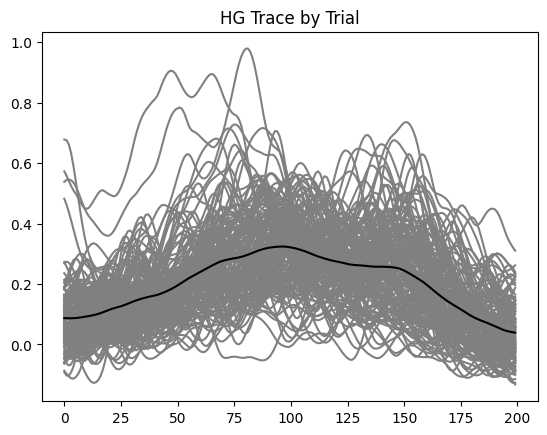

In [12]:
plt.figure()
plt.plot(np.mean(hg_trace, axis=2).T, 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=2), axis=0), 'black')
plt.title('HG Trace by Trial')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [13]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [14]:
# parameters
n_output = 10

In [15]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X = hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

In [16]:
print(X.shape, X_prior.shape, y.shape, prior_labels.shape, seq_labels.shape)

(144, 200, 111) (144, 3, 10) (144, 3, 10) (144, 3) (144, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [17]:
# imports
from seq2seq_models.rnn_models import (lstm_1Dcnn_model, gru_1Dcnn_model, 
                                       lstm_3Dcnn_model, gru_3Dcnn_model,
                                       stacked_lstm_1Dcnn_model,
                                       stacked_gru_1Dcnn_model)


In [18]:
# parameters

# 1D CNN
n_input_time = X.shape[1]
n_input_channel = X.shape[2]
filter_size = 10

# 3D CNN
# n_input_channel = [X.shape[1], X.shape[2]]
# n_input_time = X.shape[3]
# filter_size = 2

n_filters = 50
n_units = 200
n_layers = 3
reg_lambda = 1e-6
dropout = 0.0
bidir = True

In [19]:
# train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir, dropout=dropout)
# train_model, inf_enc, inf_dec = lstm_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = stacked_lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_layers, n_units, reg_lambda, bidir=bidir, dropout=dropout)
train_model, inf_enc, inf_dec = stacked_gru_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_layers, n_units, reg_lambda, bidir=bidir, dropout=dropout)

In [20]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_gru_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 111)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 50)       55550       ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 training_gru_initial (Function  (None, None, 10)    1876410     ['conv1d[0][0]',                 
 al)                                                              'input_2[0][0]'

In [15]:
new_model, new_enc, new_dec = lstm_1Dcnn_model(n_input_time, 256, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir, dropout=dropout)
for layer in new_model.layers:
        try:
            layer.set_weights(train_model.get_layer(name=layer.name).get_weights())
        except ValueError:
            print("Could not transfer weights for layer {}".format(layer.name))

Could not transfer weights for layer input_18
Could not transfer weights for layer conv1d_3
Could not transfer weights for layer input_19
Could not transfer weights for layer training_lstm_initial


In [ ]:
new_lstm_w = new_model.layers[-1].layers[1].get_weights()[0]
old_lstm_w = train_model.layers[-1].layers[1].get_weights()[0]
print(np.array_equal(new_lstm_w, old_lstm_w))
print(new_lstm_w)
print(old_lstm_w)

### Hyperparameter Optimization

In [ ]:
import keras_tuner as kt
from sklearn.model_selection import ShuffleSplit
from train.optimize import encDecHyperModel, encDecTuner

In [ ]:
data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(data_split.split(X))
X_train, X_test = X[train_idx], X[test_idx]
X_prior_train, X_prior_test = X_prior[train_idx], X_prior[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
optim_trials = 100
hyper_model = encDecHyperModel(lstm_1Dcnn_model, n_input_time, n_input_channel, n_output)
rnn_optimizer = encDecTuner(hypermodel=hyper_model,
                            oracle=kt.oracles.RandomSearchOracle(objective=kt.Objective('val_accuracy', direction='max'),
                                                                 max_trials=optim_trials),
                            directory='data/rnn_tuning', project_name='S14_1Dcnn_LSTM')

In [ ]:
rnn_optimizer.search(X_train, X_prior_train, y_train, epochs=800)

In [ ]:
rnn_optimizer.results_summary()

In [ ]:
optim_params = rnn_optimizer.get_best_hyperparameters(num_trials=10)[0].values
print(optim_params)

In [ ]:
from keras.optimizers import Adam
optim_model, optim_enc, optim_dec = lstm_1Dcnn_model(n_input_time, n_input_channel,
                                                     n_output, n_filters=optim_params['num_filts'],
                                                     filter_size=10, n_units=optim_params['rnn_units'],
                                                     reg_lambda=optim_params['reg_lambda'])

learning_rate = 5e-4
optim_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from train.train import train_seq2seq, decode_seq2seq

_, histories = train_seq2seq(optim_model, X_train, X_prior_train, y_train, epochs=800)


In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_pred_optim, y_test_optim = decode_seq2seq(optim_enc, optim_dec, X_test, y_test)
print(f'Hyperparameter Optimized Balanced Accuracy: {balanced_accuracy_score(y_test_optim, y_pred_optim)}')

### Train Model

In [21]:
# imports
import time
import tensorflow as tf
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold, train_seq2seq

In [22]:
tf.config.list_physical_devices('GPU')

[]

In [23]:
# parameters
num_folds = 10
num_reps = 1
batch_size = 200
epochs = 200
learning_rate = 1e-3

train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
from train.seq2seq_predict_callback import seq2seq_predict_callback
from sklearn.model_selection import ShuffleSplit

data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(data_split.split(X))
X_train, X_test = X[train_idx], X[test_idx]
X_prior_train, X_prior_test = X_prior[train_idx], X_prior[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

s2s_cb = seq2seq_predict_callback(train_model, inf_enc, inf_dec, X_test, y_test)

In [25]:
_, history = train_seq2seq(train_model, X_train, X_prior_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=([X_test, X_prior_test], y_test), callbacks=[s2s_cb])

Epoch 1/200
1/1 [==============================] - 16s 16s/step - loss: 2.3069 - accuracy: 0.1188 - val_loss: 2.2497 - val_accuracy: 0.1839 - seq2seq_val_loss: 2.2474 - seq2seq_val_accuracy: 0.1550
Epoch 2/200
1/1 [==============================] - 1s 508ms/step - loss: 2.2363 - accuracy: 0.1913 - val_loss: 2.1995 - val_accuracy: 0.1954 - seq2seq_val_loss: 2.2003 - seq2seq_val_accuracy: 0.1742
Epoch 3/200
1/1 [==============================] - 1s 514ms/step - loss: 2.1754 - accuracy: 0.1855 - val_loss: 2.1567 - val_accuracy: 0.1954 - seq2seq_val_loss: 2.1602 - seq2seq_val_accuracy: 0.1320
Epoch 4/200
1/1 [==============================] - 1s 582ms/step - loss: 2.1217 - accuracy: 0.2290 - val_loss: 2.1256 - val_accuracy: 0.1839 - seq2seq_val_loss: 2.1311 - seq2seq_val_accuracy: 0.1058
Epoch 5/200
1/1 [==============================] - 1s 554ms/step - loss: 2.0675 - accuracy: 0.2667 - val_loss: 2.1113 - val_accuracy: 0.2299 - seq2seq_val_loss: 2.1187 - seq2seq_val_accuracy: 0.1696
Epoch 

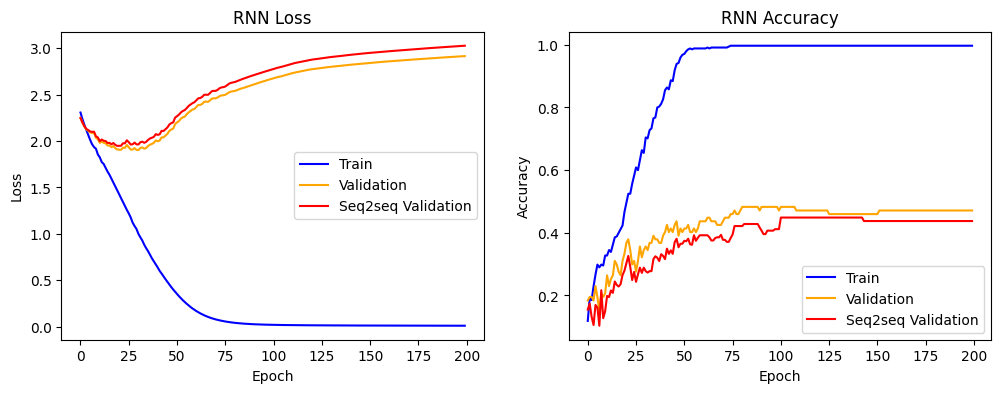

In [26]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], color='blue', label='Train')
ax1.plot(history.history['val_loss'], color='orange', label='Validation')
ax1.plot(history.history['seq2seq_val_loss'], color='red', label='Seq2seq Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], color='blue', label='Train')
ax2.plot(history.history['val_accuracy'], color='orange', label='Validation')
ax2.plot(history.history['seq2seq_val_accuracy'], color='red', label='Seq2seq Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()


plt.show()

In [ ]:
start = time.time()
histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X, X_prior, y,
                                                        num_folds=num_folds, num_reps=num_reps,
                                                        batch_size=batch_size, 
                                                        epochs=epochs, early_stop=False)
end = time.time()


In [ ]:
print(f'Time to train {num_folds} folds: {end-start} seconds')

In [ ]:
from visualization.plot_model_performance import extend_history_lists

histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Validation')
ax1.plot(np.array(histories['seq2seq_val_loss']).T, color='red', alpha=0.35)
ax1.plot(np.mean(histories['seq2seq_val_loss'], axis=0), color='red', label='Seq2seq Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Validation')
ax2.plot(np.array(histories['seq2seq_val_accuracy']).T, color='red', alpha=0.35)
ax2.plot(np.mean(histories['seq2seq_val_accuracy'], axis=0), color='red', label='Seq2seq Validation')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_all, y_pred_all)}')

In [ ]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories, epochs=epochs)